
#### Underdamped
Compare the EM scheme applied to the SDE, transformed SDE and rescaled time.  

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
import sys
# sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation/C++")

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)
import pandas as pd
import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Compare after a fixed number of steps 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=5
m=0.01
# include_ada = 2 #if 1 make the code adaptive 
printskip=100
Ntl = np.array([100,200,500,900,5000,10000])
lenNtl = len(Ntl)
# Ntl = np.array([0,1,2,3,4,5])
# lenNtl = len(Ntl)

# M=10
# m=0.01
# # includeD=False # if 1 include divergence term
# printskip=10
# Ntl = np.array([20.,120., 220., 320., 420.])*100
# lenNtl = len(Ntl)


def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
def one_traj_ada(qp,Nt,dt,gamma,tau,include_ada):
    t=0
    q=qp[0]
    p=qp[1]

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Transformed SDE
        g=getg(q)
        gp=getgprime(q)
    elif include_ada==2:     # Rescaled SDE
         g=getg(q)
        
    
    gdt=g*dt

    #set up vectors to save results 
    size_save = int(lenNtl) #int(Nt/printskip)
    tqpg_list = np.zeros((size_save,4))
    save_i=0 



    for count in range(Nt):
        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1                    # Normal SDE                
        if include_ada==1:     # Transformed SDE
            g=getg(q)
            gp=getgprime(q)
        elif include_ada==2:   # Rescaled SDE
            g=getg(q)
        
        gdt=g*dt

        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if count==Ntl[save_i]:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            tqpg_list[save_i,3]=g
            save_i+=1
            
        if include_ada==1: # in the case of transformed move time forward using dt
            t+= dt 
        else:              # in the case of rescaled (time moved using gdt) and normal em (time moved forward using gdt=1*dt)
            t+=gdt
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada):
    nsample_pertraj = int(lenNtl)
    tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
    ones_nsample=np.ones(nsample_pertraj)
    qipi = np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
    for j in nb.prange(n_samples):
        qp_samples = one_traj_ada(qipi,Nt,h,gamma,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:5]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_ada(2,0.1,1,10,0.1,2)

#### verify that the code works properly

In [3]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Ntimes=int(T*1/h)+1
include_ada=1
qp_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h,include_ada)


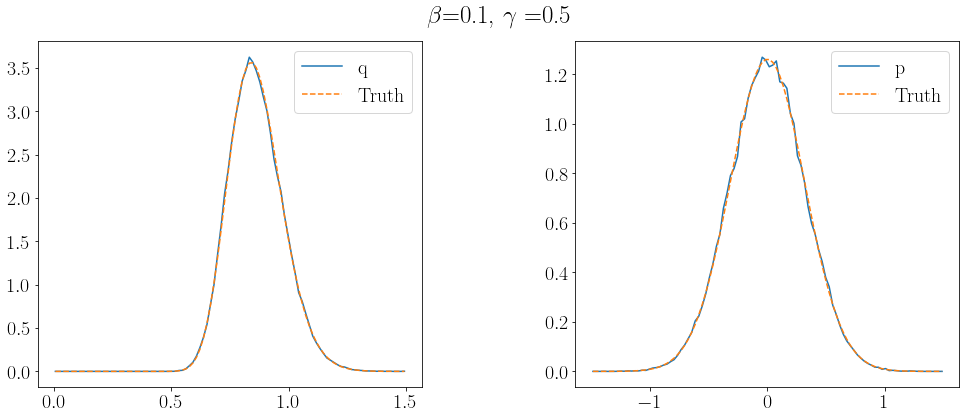

In [4]:
import pandas as pd
df = pd.DataFrame(qp_ada,columns=["sim","t","Q","P","g"])
#Create a dataset with only the final time
idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
final_df=df[idx] #Select only dataset with final time
#Get numpy arrays of the final values 
qf_list,pf_list,gf_list,tf_list = np.array(final_df["Q"]), np.array(final_df["P"]), np.array(final_df["g"]), np.array(final_df["t"])

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

#Plot 1
## position q experiment - C CODE
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q')
ax1.legend() 

#Plot 2: 
### momentum p experiment NUMBA CODE
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p')

### position q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Truth')
ax1.legend() 

### momentum p true
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='Truth')
ax2.legend() 

### Now compare results

In [6]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Nt=int(T*1/h)+1

# if include_ada==0 No adaptivity 
include_ada=0   
%time pqnoada= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)

# if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
include_ada=1
%time pqemtotranssde= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pqemtonontranssde= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)

CPU times: user 1min 41s, sys: 99.4 ms, total: 1min 41s
Wall time: 9.5 s
CPU times: user 3min 31s, sys: 264 ms, total: 3min 32s
Wall time: 20 s
CPU times: user 2min 49s, sys: 184 ms, total: 2min 49s
Wall time: 17.1 s


In [7]:
import pandas as pd
df_noada = pd.DataFrame(pqnoada,columns=["sim","t","q","p","g"])
df_transfo = pd.DataFrame(pqemtotranssde,columns=["sim","t","q","p","g"])
df_rescale = pd.DataFrame(pqemtonontranssde,columns=["sim","t","q","p","g"])
# df_ynoada_true = pd.DataFrame(ynoada_true,columns=["sim","step","t","x","g","gp"])

In [8]:
## add the steps per iterations
# Number the saved value in each dataset such that we can compare times easily 
df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1
df_transfo['count'] = df_rescale.groupby(['sim']).cumcount()+1
df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1

### Look at final distribution 

In [9]:
def look_at_final(df):
    # df = pd.DataFrame(df,columns=["sim","t","Q","P","g"])
    #Create a dataset with only the final time
    idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
    final_df=df[idx] #Select only dataset with final time
    qf_list,pf_list,gf_list,tf_list = np.array(final_df["q"]), np.array(final_df["p"]), np.array(final_df["g"]), np.array(final_df["t"])
    return(qf_list,pf_list,gf_list,tf_list)

qf_list,pf_list,gf_list,tf_list = look_at_final(df_noada)


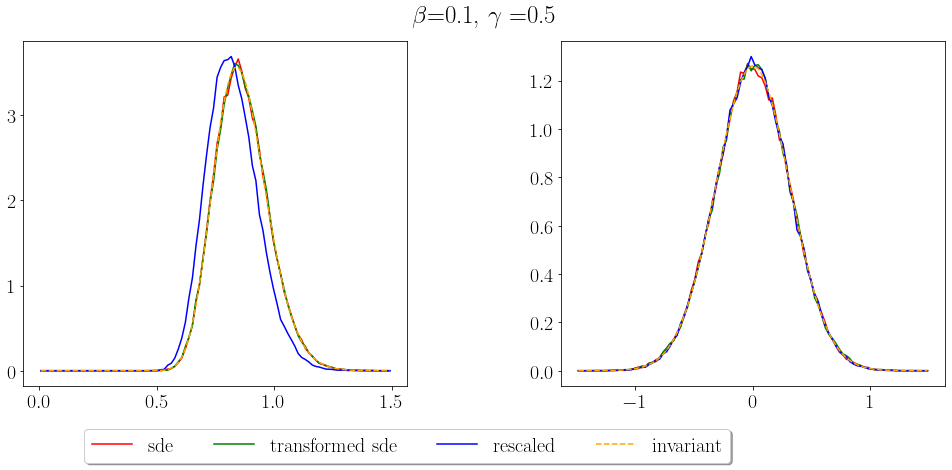

In [10]:

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

# No ada 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_noada)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='sde',color="red")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='sde',color="red")

# Ada transfo 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_transfo)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='transformed sde',color="green")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='transformed sde',color="green")

# Rescale 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_rescale)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='rescaled',color="blue")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='rescaled',color="blue")



### position q invariant
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='invariant',color="orange")
#ax1.legend() 

### momentum p invariant
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='invariant',color="orange")

ax2.legend(loc='lower center',bbox_to_anchor=(-0.4, -.25),
          ncol=4, fancybox=True, shadow=True)


### Look at the distribution of times to see whether it sounds logical that we reach the right distribution

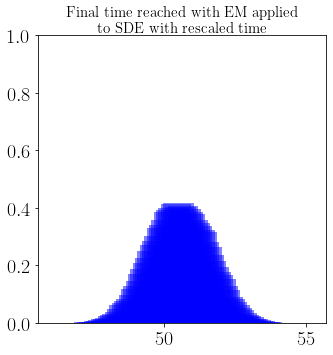

In [17]:
list_time_rescale=df_rescale[df_rescale['count']==6]['t']

## Set up the plots 
fig, ((axs))= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Final time reached with EM applied \nto SDE with rescaled time", fontsize=15)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

var = list_time_rescale
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
axs.bar(midx,histogram,width=(upperbound-lowerbound)/nbins+1,color="blue",label="No ada",alpha=0.5)
axs.set_ylim([0,1])
fig.savefig('distr_final_timeM'+str(M)+"m"+str(m)+"Nt"+str(Nt)+"h"+str(h)+"tau"+str(tau)+".png")

final distribution seems to be matching, one needs to look at evolving distributions 

In [13]:
## Get a list of 10 times 
list_step=df_noada['count'].unique()
print(list_step)

[1 2 3 4 5 6]


In [1]:
## Set up the plots 
fig, ((axs))= plt.subplots(2,len(list_step),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('underdamped-evolving distributions M='+str(M)+', m=' +str(m)+", $\gamma=$"+str(gamma)+", $\\tau$="+str(tau), fontsize=25)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

b_p=3 #bounds for p distr
## Loop through the values 
for i in range(len(list_step)):
    
    # List of time
    counti = list_step[i]
    # * Dataframe 
    df_noada_i=df_noada[df_noada['count']==counti]

    # --- No ada
    histogram,bins = np.histogram(df_noada_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='SDE',color="red")
    
    histogram,bins = np.histogram(df_noada_i["p"],bins=100,range=[-b_p,b_p], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='SDE',color="red")
    
   
    # --- Transformed SDE
    df_transfo_i=df_transfo[df_transfo['count']==counti]
    histogram,bins = np.histogram(df_transfo_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='transformed SDE',color="green")

    histogram,bins = np.histogram(df_transfo_i["p"],bins=100,range=[-b_p,b_p], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='transformed SDE',color="green")


    # --- Rescaled time
        # * Dataframe 
    df_rescale_i=df_rescale[df_rescale['count']==counti]
    histogram,bins = np.histogram(df_rescale_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='rescaled time',color="blue")
    axs[0,i].set_ylabel("Q")

    histogram,bins = np.histogram(df_rescale_i["p"],bins=100,range=[-b_p,b_p], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='rescaled time',color="blue")
    axs[1,i].set_ylabel("P")

    # --- True
    # histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    # midx_q = (bins[0:-1]+bins[1:])/2
    # axs[i].plot(midx_q,histogram,"x",label='EM to non transformed SDE (small h)',color="magenta")

    # --- P invariant
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    axs[1,i].plot(midx_p,rho,'--',label='Truth',color="orange")

    # --- Q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[0,i].plot(midx_q,rho,'--',label='invariant',color="orange")

    axs[0,i].set_title("steps="+str(np.round(Ntl[i],0)),fontsize= 20)

    # parameters of axis
    axs[0,i].set_ylim([0, 10])
    axs[1,i].set_ylim([0, 1.5])



axs[0,len(list_step)-1].legend(loc='lower center',bbox_to_anchor=(-2.5, 1.06),
           ncol=5, fancybox=True, shadow=True)


fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")

NameError: name 'plt' is not defined

### Now need to look at fixed time rather than fixed step



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=5
m=0.01
# include_ada = 2 #if 1 make the code adaptive 
printskip=100
Tl = np.array([0.5,1,5,10,50,99])
lenTl = len(Tl)
def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
def one_traj_ada(qp,T,dt,gamma,tau,include_ada):
    t=0
    q=qp[0]
    p=qp[1]

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Transformed SDE
        g=getg(q)
        gp=getgprime(q)
    elif include_ada==2:     # Rescaled SDE
         g=getg(q)
        
    
    gdt=g*dt

    #set up vectors to save results 
    size_save = int(lenTl)*10 #int(Nt/printskip)
    tqpg_list = np.zeros((size_save,4))
    save_i=0 
    count=0


    while t<T:
        count+=1

        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1                    # Normal SDE                
        if include_ada==1:     # Transformed SDE
            g=getg(q)
            gp=getgprime(q)
        elif include_ada==2:   # Rescaled SDE
            g=getg(q)

        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if t>Tl[save_i]:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            tqpg_list[save_i,3]=count

            save_i+=1

        if include_ada==1: # in the case of transformed move time forward using dt
            t+= dt 
        else:              # in the case of rescaled (time moved using gdt) and normal em (time moved forward using gdt=1*dt)
            t+=gdt
    t = np.round(t,6)
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,T,h,include_ada):
    nsample_pertraj = int(lenTl)*10
    tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
    ones_nsample=np.ones(nsample_pertraj)
    qipi = np.abs(np.random.normal(0,1,2)) #initial conditions
    for j in nb.prange(n_samples):
        qp_samples = one_traj_ada(qipi,T,h,gamma,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:5]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_ada(2,0.1,0.1,10,0.1,0)

In [21]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Nt=int(T*1/h)+1

# if include_ada==0 No adaptivity 
include_ada=0   
%time pqnoada= method_baoab_ada(n_samples,gamma,tau,T,h,include_ada)

# if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
include_ada=1
%time pqemtotranssde= method_baoab_ada(n_samples,gamma,tau,T,h,include_ada)

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pqemtonontranssde= method_baoab_ada(n_samples,gamma,tau,T,h,include_ada)


CPU times: user 1min 21s, sys: 255 ms, total: 1min 21s
Wall time: 7.7 s
CPU times: user 3min 8s, sys: 300 ms, total: 3min 8s
Wall time: 17.7 s


In [ ]:
import pandas as pd
df_noada = pd.DataFrame(pqnoada,columns=["sim","t","q","p","step"])
df_transfo = pd.DataFrame(pqemtotranssde,columns=["sim","t","q","p","step"])
df_rescale = pd.DataFrame(pqemtonontranssde,columns=["sim","t","q","p","step"])

df_noada=df_noada[df_noada['t']!=0]
df_transfo=df_transfo[df_transfo['t']!=0]
df_rescale=df_rescale[df_rescale['t']!=0]

In [ ]:
# Number the saved value in each dataset such that we can compare times easily 
df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1
df_transfo['count'] = df_transfo.groupby(['sim']).cumcount()+1
df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1


In [ ]:
list_step=df_noada['count'].unique()
list_step

array([1, 2, 3, 4, 5, 6])

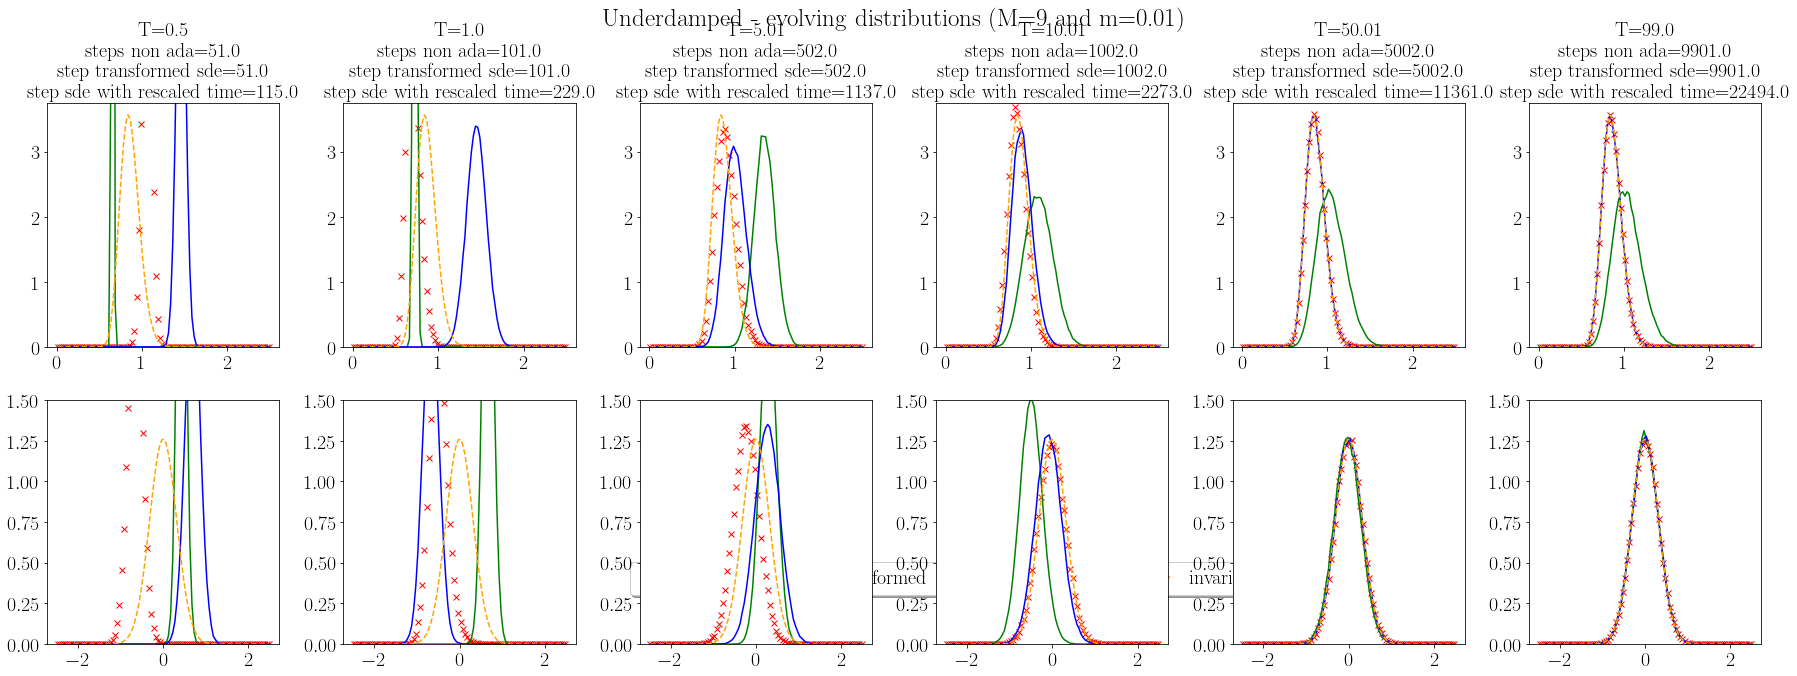

In [136]:
## Set up the plots 
fig, ((axs))= plt.subplots(2,len(list_step),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('underdamped-evolving distributions M='+str(M)+', m=' +str(m)+", $\gamma=$"+str(gamma)+", $\\tau$="+str(tau), fontsize=25)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
for i in range(len(list_step)):
    
    # List of time
    counti = list_step[i]
    # * Dataframe 
    df_noada_i=df_noada[df_noada['count']==counti]

    # --- No ada
    histogram,bins = np.histogram(df_noada_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,'x',label='SDE',color="red")
    
    histogram,bins = np.histogram(df_noada_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,'x',label='SDE',color="red")
    
   
    # --- Transformed SDE
    df_transfo_i=df_transfo[df_transfo['count']==counti]
    histogram,bins = np.histogram(df_transfo_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='Transformed',color="green")

    histogram,bins = np.histogram(df_transfo_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='Transformed',color="green")


    # --- Rescaled time
        # * Dataframe 
    df_rescale_i=df_rescale[df_rescale['count']==counti]
    histogram,bins = np.histogram(df_rescale_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='Rescaled',color="blue")
    
    histogram,bins = np.histogram(df_rescale_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='Rescaled',color="blue")

    # --- True
    # histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    # midx_q = (bins[0:-1]+bins[1:])/2
    # axs[i].plot(midx_q,histogram,"x",label='EM to non transformed SDE (small h)',color="magenta")

    # --- P invariant
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    axs[1,i].plot(midx_p,rho,'--',label='Truth',color="orange")

    # --- Q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[0,i].plot(midx_q,rho,'--',label='invariant',color="orange")

    axs[0,i].set_title("t="+str(np.round(Tl[i],0)),fontsize= 20)

    # parameters of axis
    axs[0,i].set_ylim([0, 3.75])
    axs[1,i].set_ylim([0, 1.5])

    # non adaptive steps 
    titlei="T="+str(round(df_noada_i['t'].unique()[0],2))+"\n steps non ada="+str(df_noada_i['step'].unique()[0])+"\n step transformed sde="+str(df_transfo_i['step'].unique()[0])+"\n step sde with rescaled time="+str(df_rescale_i['step'].unique()[0])
    axs[0,i].set_title(titlei)


axs[0,len(list_step)-1].legend(loc='lower center',bbox_to_anchor=(-2.5, -1.06),
           ncol=5, fancybox=True, shadow=True)


fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")

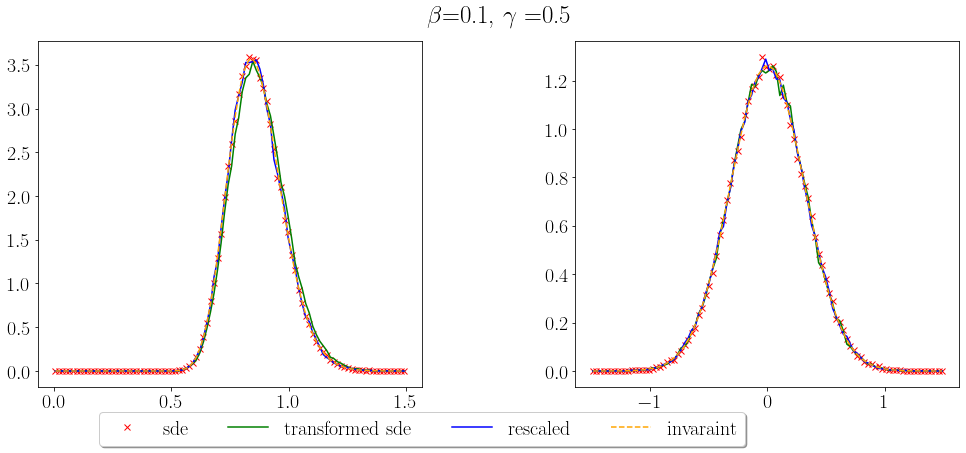

In [115]:

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

# No ada 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_noada)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,'x',label='sde',color="red")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,'x',label='sde',color="red")

# Ada transfo 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_transfo)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='transformed sde',color="green")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='transformed sde',color="green")

# Rescale 
qf_list,pf_list,gf_list,tf_list = look_at_final(df_rescale)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='rescaled',color="blue")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='rescaled',color="blue")



### position q invariant
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='invariant',color="orange")
#ax1.legend() 

### momentum p invariant
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='invaraint',color="orange")
ax2.legend(loc='lower center',bbox_to_anchor=(-.4, -.2),
           ncol=5, fancybox=True, shadow=True)
